In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm
import torch
from torch import nn
import gin
import pickle
import io
from sparse_causal_model_learner_rl.trainable.gumbel_switch import WithInputSwitch, sample_from_logits_simple
gin.enter_interactive_mode()
from sparse_causal_model_learner_rl.loss.losses import fit_loss
from sparse_causal_model_learner_rl.metrics.context_rewrite import context_rewriter
from sparse_causal_model_learner_rl.visual.learner_visual import graph_for_matrices

In [2]:
ckpt = '/home/sergei/ray_results/5x5_1f1c1k_rec_nonlin_gnn_gumbel_siamese_l2_stop_after_completes/main_fcn_ced98_00000_0_2021-01-30_08-57-32/checkpoint_5000/checkpoint'

In [3]:
class LinearModel(nn.Module):
    def __init__(self, input_shape):
        super(LinearModel, self).__init__()
        self.layer = nn.Linear(in_features=10, out_features=1, bias=True)
    def forward(self, x):
        return self.layer(x)

In [4]:
import ray
ray.init(address='10.90.38.7:6379', ignore_reinit_error=True)

2021-01-30 21:07:25,510	INFO worker.py:651 -- Connecting to existing Ray cluster at address: 10.90.38.7:6379


{'node_ip_address': '10.90.38.7',
 'raylet_ip_address': '10.90.38.7',
 'redis_address': '10.90.38.7:6379',
 'object_store_address': '/tmp/ray/session_2021-01-29_10-33-31_725376_19160/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-01-29_10-33-31_725376_19160/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2021-01-29_10-33-31_725376_19160',
 'metrics_export_port': 42346,
 'node_id': 'f237fb11fb3bc81e67f20ea7d86350e858dd333a'}

In [5]:
# https://github.com/pytorch/pytorch/issues/16797
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [6]:
with open(ckpt, 'rb') as f:
    learner = pickle.load(f)#CPU_Unpickler(f).load()#pickle.load(f)

2021-01-30 21:07:29,719	WARNING session.py:20 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Selecting name c7e54d1a-6336-11eb-af1d-90e2baa1a248
Make environment KeyChest-v0 None {}


In [7]:
learner.collect_steps()

In [8]:
ctx = learner._context

In [9]:
ox = ctx['obs_x']
oy = ctx['obs_y']
ax = ctx['action_x']

In [10]:
from keychest.features_xy import dict_to_arr, arr_to_dict, obs_features_handcoded

keys = sorted(obs_features_handcoded(learner.env.engine).keys())
keys_add = learner.additional_feature_keys

In [11]:
true_model = {
    'button__x': ['button__x'],
    'button__y': ['button__y'],
    'chest__00__x': ['chest__00__x', 'chest__00__y', 'keys', 'player__x', 'player__y'],
    'chest__00__y': ['chest__00__x', 'chest__00__y', 'keys', 'player__x', 'player__y'],
    'food__00__x': ['food__00__x', 'food__00__y', 'player__x', 'player__y'],
    'food__00__y': ['food__00__x', 'food__00__y', 'player__x', 'player__y'],
    'health': ['food__00__x', 'food__00__y', 'player__x', 'player__y', 'health'],
    'key__00__x': ['key__00__x', 'key__00__y', 'player__x', 'player__y'],
    'key__00__y': ['key__00__x', 'key__00__y', 'player__x', 'player__y'],
    'keys': ['keys', 'key__00__x', 'key__00__y', 'player__x', 'player__y', 'chest__00__x', 'chest__00__y'],
    'lamp_off__x': ['lamp_off__x', 'lamp_on__x', 'button__x', 'button__y', 'player__x', 'player__y'],
    'lamp_off__y': ['lamp_off__y', 'lamp_on__y', 'button__x', 'button__y', 'player__x', 'player__y'],
    'lamp_on__x': ['lamp_off__x', 'lamp_on__x', 'button__x', 'button__y', 'player__x', 'player__y'],
    'lamp_on__y': ['lamp_off__y', 'lamp_on__y', 'button__x', 'button__y', 'player__x', 'player__y'],
    'lamp_status': ['lamp_on__x', 'lamp_on__y', 'lamp_off__x', 'lamp_off__y', 'player__x', 'player__y'],
    'player__x': ['player__x'],
    'player__y': ['player__y'],
    'done_y': ['player__x', 'player__y', 'food__00__x', 'food__00__y', 'health'],
    'rew_y': ['player__x', 'player__y', 'food__00__x', 'food__00__y', 'key__00__x', 'key__00__y', 'chest__00__x', 'chest__00__y']
}

true_model_a = {
    'player__x': [0, 1, 2, 3],
    'player__y': [0, 1, 2, 3]
}

df_a_true = pd.DataFrame(np.zeros_like(learner.model.Ma), columns=[0, 1, 2, 3], index=keys+keys_add)

for key, vals in true_model_a.items():
    for v in vals:
        df_a_true.loc[key, v] = 1.0

df_true = pd.DataFrame(np.zeros_like(learner.model.Mf), columns=keys, index=keys+keys_add)
for key, vals in true_model.items():
    for v in vals:
#         print(key, v)
        df_true.loc[key, v] = 1.0

<AxesSubplot:>

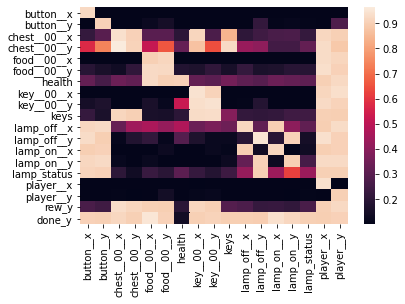

In [12]:
sns.heatmap(pd.DataFrame(learner.model.Mf, columns=keys, index=keys+keys_add))

<AxesSubplot:>

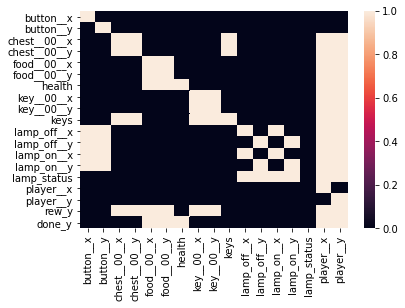

In [13]:
sns.heatmap(df_true)

<AxesSubplot:>

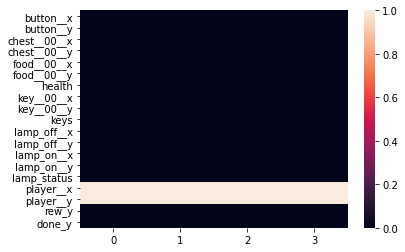

In [14]:
sns.heatmap(df_a_true)

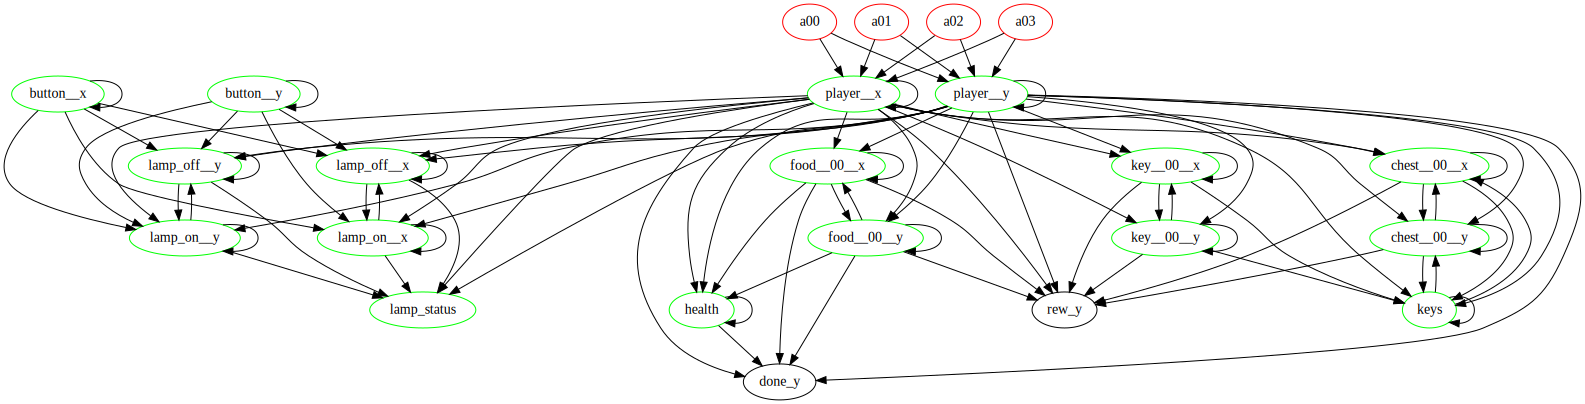

In [16]:
m = learner
m.Mf = df_true
m.Ma = df_a_true
graph_for_matrices(m, feature_names=keys)[0]

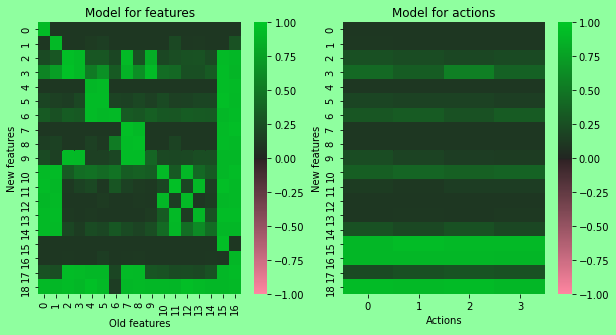

In [30]:
f = learner.visualize_model()

In [20]:
pd.DataFrame(learner.model.Mf, index=keys+keys_add, columns=keys)

,button__x,button__y,chest__00__x,chest__00__y,food__00__x,food__00__y,health,key__00__x,key__00__y,keys,lamp_off__x,lamp_off__y,lamp_on__x,lamp_on__y,lamp_status,player__x,player__y
button__x,0.924633,0.105748,0.105720,0.105753,0.105707,0.105770,0.105694,0.105592,0.105762,0.105660,0.105727,0.105757,0.105722,0.105746,0.105743,0.105744,0.105755
button__y,0.105812,0.905539,0.105820,0.105814,0.125930,0.150143,0.105818,0.105777,0.105820,0.105816,0.105757,0.217541,0.110249,0.116899,0.107301,0.105783,0.276191
chest__00__x,0.221025,0.297058,0.940652,0.905741,0.302145,0.301211,0.198992,0.915866,0.270375,0.842135,0.206812,0.242635,0.267557,0.272335,0.218933,0.918361,0.902982
chest__00__y,0.576795,0.740136,0.965575,0.911341,0.520392,0.658159,0.325863,0.871919,0.645339,0.925200,0.431602,0.409791,0.251634,0.251185,0.321280,0.930762,0.884782
food__00__x,0.105766,0.105720,0.105730,0.105741,0.903251,0.916137,0.105745,0.105758,0.105727,0.105797,0.105685,0.105681,0.105802,0.105747,0.105785,0.930086,0.917336
food__00__y,0.192876,0.160035,0.140406,0.208894,0.927869,0.923776,0.180548,0.170737,0.211183,0.157536,0.221171,0.163328,0.170212,0.193159,0.191653,0.937455,0.907585
health,0.321552,0.261978,0.339877,0.316812,0.926668,0.901567,0.905876,0.322163,0.303453,0.355918,0.311393,0.296125,0.339113,0.324294,0.312893,0.901627,0.924644
key__00__x,0.105693,0.105674,0.105690,0.105521,0.105745,0.105744,0.105690,0.944654,0.908631,0.105676,0.105672,0.105679,0.105702,0.105693,0.105719,0.915438,0.936296
key__00__y,0.149653,0.170405,0.105682,0.105793,0.160303,0.118663,0.528611,0.935739,0.942750,0.105807,0.107428,0.183693,0.105788,0.105776,0.105752,0.925082,0.908910
keys,0.223442,0.161661,0.916396,0.904029,0.160979,0.156525,0.198478,0.931214,0.932156,0.390347,0.218392,0.210376,0.218527,0.242697,0.244172,0.902796,0.900605


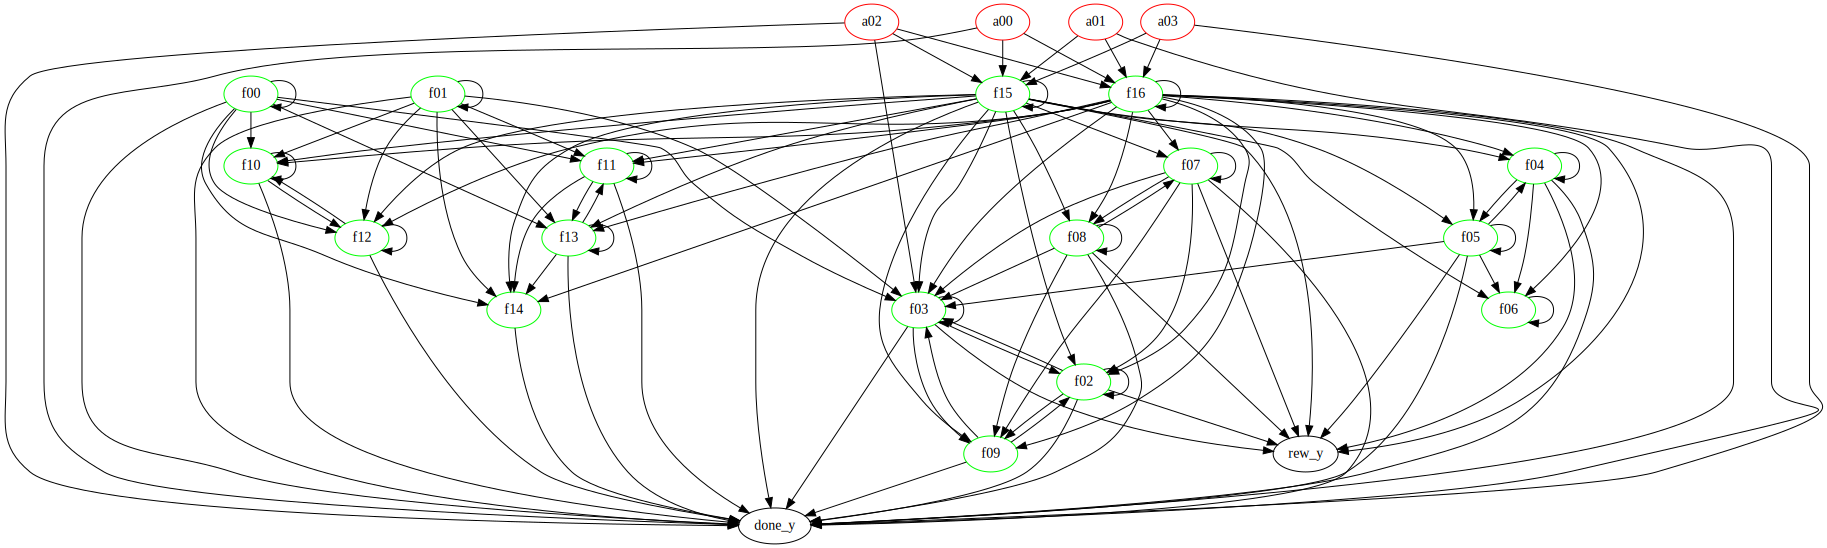

In [17]:
learner.visualize_graph()[1]

In [23]:
context_rewriter(function=fit_loss,
                rewrite={'model': 'non_sparse_model'},
                **ctx)

{'loss': tensor(4.3803e-05, device='cuda:0', grad_fn=<AddBackward0>),
 'metrics': {'mean_feature': 0.6663761138916016,
  'mean_additional_feature': 0.05923672392964363,
  'loss_main': 4.152982364757918e-05,
  'loss_additional': 2.272763822475099e-06}}

In [24]:
fit_loss(**ctx)

{'loss': tensor(0.0409, device='cuda:0', grad_fn=<AddBackward0>),
 'metrics': {'mean_feature': 0.6663761138916016,
  'mean_additional_feature': 0.05923672392964363,
  'loss_main': 3.634785389294848e-05,
  'loss_additional': 0.04087341949343681}}

In [11]:
oy_pred = learner.model(f_t=ox, a_t=ax)
oy_pred_nosparse = learner.non_sparse_model(f_t=ox, a_t=ax)

In [ ]:
        add_features_y = torch.cat([kwargs[k] for k in additional_feature_keys], dim=1)
        loss_additional = mse(model(decoder(obs_x), action_x, additional=True), add_features_y)

In [29]:
learner.model(f_t=ox, a_t=ax, additional=True)

tensor([[ 2.3909e-04,  1.1392e-01],
        [ 1.0046e-01,  1.0674e-01],
        [ 2.9988e-01,  7.9058e-02],
        ...,
        [ 2.8248e-05,  5.7320e-02],
        [-1.6586e-05,  6.1120e-02],
        [-8.4626e-05,  6.9533e-02]], device='cuda:0', grad_fn=<CatBackward>)

In [27]:
(oy_pred - oy).pow(2).mean()

tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)

In [28]:
(oy_pred_nosparse - oy).pow(2).mean()

tensor(4.2184e-05, device='cuda:0', grad_fn=<MeanBackward0>)

<AxesSubplot:>

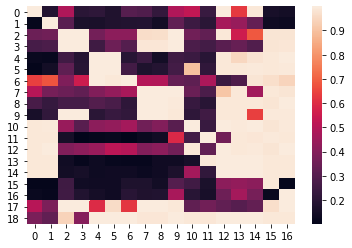

In [179]:
sns.heatmap(learner.model.Mf)

<AxesSubplot:>

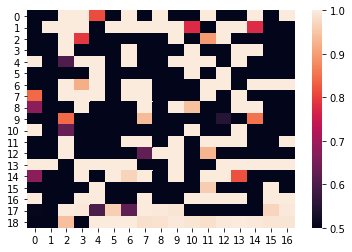

In [217]:
sns.heatmap(learner.model.Mf)

In [218]:
# most features are bad
(oy_pred - oy).pow(2).mean(0)

tensor([0.4873, 0.4832, 0.3657, 0.3342, 0.5606, 0.5150, 0.3995, 0.4041, 0.4693,
        1.2049, 0.5493, 0.3676, 1.1948, 1.0183, 0.9657, 0.4987, 0.5061],
       device='cuda:0', grad_fn=<MeanBackward1>)

In [316]:
# random init
ms = learner.non_sparse_model.all_models
for m in ms:
    getattr(learner.model, m).model.__init__(input_shape=(learner.model.n_features + learner.model.n_actions,),
                                            output_shape=(1,))
    getattr(learner.model, m).model.to(learner.device)
# list(getattr(learner.model, ms[0]).model.fc01.parameters())

In [387]:
opt = torch.optim.Adam(params=learner.model.model__params, lr=1e-3)

In [318]:
for m in learner.model.all_models:
    getattr(learner.model, m).switch.sample_threshold = 0.9

In [238]:
assert learner.non_sparse_model.all_models == learner.model.all_models
for key in learner.non_sparse_model.all_models:
    m_nsp_i = getattr(learner.non_sparse_model, key)
    m_i = getattr(learner.model, key).model
    m_i.load_state_dict(m_nsp_i.state_dict())

In [223]:
losses = []

In [382]:
opt = torch.optim.Adam(params=learner.model.switch__params, lr=1e-3)

In [ ]:
for _ in tqdm(range(50000)):
    opt.zero_grad()
    oy_pred = learner.model(f_t=ox, a_t=ax)
    loss = (oy_pred - oy).pow(2).mean()
    loss.backward()
    opt.step()
    losses.append(loss.item())

In [284]:
### 

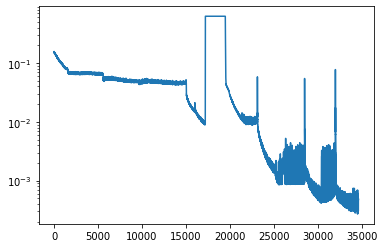

In [393]:
plt.plot(losses)
plt.yscale('log')

In [337]:
[x[1].min() for x in learner.model.switch__params]

[tensor(-0.3150, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.3007, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.1131, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.1347, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.2559, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.1408, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.5359, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.7687, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.1943, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.2939, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.1320, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.3136, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.0301, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(1.0984, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.1221, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.5223, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.3726, device='cuda:0', grad_fn=<MinBackward1>),
 te

In [366]:
[getattr(learner.model, m).switch.softmaxed().min() for m in learner.model.all_models]

[tensor(0.3911, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.4499, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.6723, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.5477, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.0262, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.5568, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.4919, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.0939, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.6468, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.1814, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.2581, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.6737, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.2943, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.9007, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.1432, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.6316, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.4051, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.5000

In [341]:
for p in learner.model.switch__params:
    p_orig = p.data.detach().clone()
    print(p_orig)
#     break
    p.data[1, p_orig[1] < 0] = 0
    p.data[0, p_orig[1] < 0] = 0

tensor([[-2.2689, -0.1689, -6.2526, -1.0999,  0.1009, -0.1912, -4.0945, -1.1123,
         -6.4583, -1.0994, -2.2313, -6.3194, -1.1019, -1.0992, -6.4341,  0.3251,
         -5.4444, -3.3842, -2.6222, -2.6231, -2.4681],
        [ 2.2689,  0.1689,  6.2526,  1.0999, -0.1009,  0.1912,  4.0945,  1.1123,
          6.4584,  1.0994,  2.2313,  6.3194,  1.1019,  1.0992,  6.4341, -0.3251,
          5.4444,  3.3842,  2.6222,  2.6231,  2.4681]], device='cuda:0')
tensor([[ 0.3160, -7.8777, -6.9329, -6.2106, -1.0990, -5.4199, -6.4777, -7.7424,
         -7.1228, -7.3047, -1.0988, -1.5841, -7.5017, -7.3072, -1.1531,  0.2827,
         -0.9270, -1.0993, -6.6940, -1.0990, -6.3193],
        [-0.3160,  7.8772,  6.9329,  6.2106,  1.0990,  5.4199,  6.4778,  7.7421,
          7.1228,  7.3047,  1.0988,  1.5841,  7.5016,  7.3072,  1.1531, -0.2827,
          0.9270,  1.0993,  6.6940,  1.0990,  6.3193]], device='cuda:0')
tensor([[-0.3735, -0.3550, -8.6088, -5.1537, -0.3251, -0.9286, -0.6295, -0.1110,
         -0.254

In [111]:
for key, param in learner.model.named_parameters():
    if 'switch' not in key:
        print(key)
        if 'bias' in key:
            torch.nn.init.zeros_(param)
        else:
            torch.nn.init.xavier_uniform_(param)

model_fout_0000.model.fc01.weight
model_fout_0000.model.fc01.bias
model_fout_0000.model.fc02.weight
model_fout_0000.model.fc02.bias
model_fout_0000.model.fc03.weight
model_fout_0000.model.fc03.bias
model_fout_0000.model.fc04.weight
model_fout_0000.model.fc04.bias
model_fout_0001.model.fc01.weight
model_fout_0001.model.fc01.bias
model_fout_0001.model.fc02.weight
model_fout_0001.model.fc02.bias
model_fout_0001.model.fc03.weight
model_fout_0001.model.fc03.bias
model_fout_0001.model.fc04.weight
model_fout_0001.model.fc04.bias
model_fout_0002.model.fc01.weight
model_fout_0002.model.fc01.bias
model_fout_0002.model.fc02.weight
model_fout_0002.model.fc02.bias
model_fout_0002.model.fc03.weight
model_fout_0002.model.fc03.bias
model_fout_0002.model.fc04.weight
model_fout_0002.model.fc04.bias
model_fout_0003.model.fc01.weight
model_fout_0003.model.fc01.bias
model_fout_0003.model.fc02.weight
model_fout_0003.model.fc02.bias
model_fout_0003.model.fc03.weight
model_fout_0003.model.fc03.bias
model_fout